In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [4]:
dataset = pd.read_pickle('/data2/cehou/LLM_safety/img_text_data/finished/Stockholm_dataset_baseline_baseline_baseline_baseline_all_4910.pkl')
dataset.head()

,GSV_idx,panoid,age,gender,location,event,text_description_all,text_description_baseline
0,0,zzcn_7ZfSJioXBih4kuKfA_180,baseline,baseline,baseline,baseline,"[[INST] \n[""Please design a street safety per...",The panoramic street view image shows a street...
1,1,zYO_pdC_oA9yk0gewKDJ3A_0,baseline,baseline,baseline,baseline,"[[INST] \n[""Please design a street safety per...",The panoramic street view image depicts a tree...
2,2,ZYNBrgLMfB2TsuDR5sTv3Q_90,baseline,baseline,baseline,baseline,"[[INST] \n[""Please design a street safety per...",The panoramic street view image depicts a city...
3,3,ZYaSZs2K6bji78qt85XAgg_0,baseline,baseline,baseline,baseline,"[[INST] \n[""Please design a street safety per...",The panoramic street view image shows a quiet ...
4,4,zY2OFuTYvuteu4yQ-SHg3A_90,baseline,baseline,baseline,baseline,"[[INST] \n[""Please design a street safety per...",The panoramic street view image depicts a busy...


In [9]:
dataset.to_csv('/data2/cehou/LLM_safety/img_text_data/finished/Stockholm_dataset_baseline_baseline_baseline_baseline_all_4910.csv', index=False)

In [3]:
aaa = pd.read_csv("/data2/cehou/LLM_safety/Stockholm/safety_score_dataset_creating.csv")

In [4]:
aaa.rename(columns={"Image_ID":"panoid"},inplace=True)

In [5]:
aaa.to_csv("/data2/cehou/LLM_safety/Stockholm/safety_score_dataset_creating.csv", index=False)

In [150]:
file_path = "/data2/cehou/LLM_safety/Stockholm/safety_ai.csv"
safety_score = pd.read_csv(file_path)
safety_score = safety_score.drop(index=0).reset_index(drop=True)
safety_score['winner'] = safety_score.apply(lambda x: x['ImageID_A'] if x['Safe_Unsafe'] == "Trygg" else x['ImageID_B'], axis=1)
safety_score['loser'] = safety_score.apply(lambda x: x['ImageID_A'] if x['Safe_Unsafe'] == "Otrygg" else x['ImageID_B'], axis=1)

In [151]:
safety_score['Panel Member_Age'] = safety_score['Panel Member_Age'].astype(int)

In [152]:
safety_score = safety_score[safety_score['Panel Member_Age'] < 55]
# safety_score = safety_score[safety_score['Panel Member_Gender'] == 'Man']

<Axes: ylabel='Frequency'>

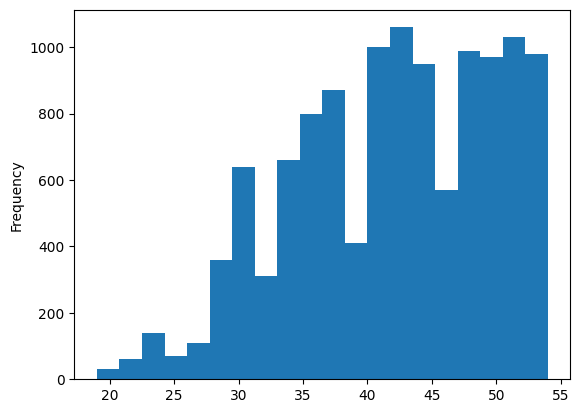

In [153]:
safety_score['Panel Member_Age'].astype(int).plot(kind='hist', bins=20)

In [154]:
img_all_idx = safety_score['ImageID_B'].value_counts().index.tolist() + safety_score['ImageID_A'].value_counts().index.tolist()
img_all_idx = set(img_all_idx)

In [155]:
def cal_safety_score(safety_score, img_id):
    all_img = safety_score[(safety_score['ImageID_A'] == img_id) | (safety_score['ImageID_B'] == img_id)]
    p_i = all_img[all_img['winner'] == img_id]['winner'].count()
    n_i = all_img[all_img['winner'] != img_id]['winner'].count()
    positive_rate = p_i / all_img['winner'].count()
    negative_rate = n_i / all_img['winner'].count()
    # print("positive rate: ", positive_rate)
    # print("negative rate: ", negative_rate)
    # safety_score_value = 10/3 * (positive_rate + positive_rate/p_i - negative_rate/n_i + 1)
    return p_i, n_i, positive_rate, negative_rate

In [156]:
# calculate positive rate and negative rate
# otrygg - unsafe, trygg - safe
safety_score_value_ls = []
for img_id in tqdm(img_all_idx):
    p_i, n_i, positive_rate, negative_rate = cal_safety_score(safety_score, img_id)
    all_img = safety_score[(safety_score['ImageID_A'] == img_id) | (safety_score['ImageID_B'] == img_id)]
    sub_negative_rate_ls = []
    sub_positive_rate_ls = []
    for i, row in all_img.iterrows():
        if row['winner'] == img_id: # winner
            _, _, _, sub_positive_rate = cal_safety_score(safety_score, row['loser'])
            sub_positive_rate_ls.append(sub_positive_rate)
        else: # loser
            _, _, sub_negative_rate, _ = cal_safety_score(safety_score, row['winner'])
            sub_negative_rate_ls.append(sub_negative_rate)

    if p_i == 0:
        score = 10/3 * (positive_rate - sum(sub_negative_rate_ls)/n_i + 1)
    elif n_i == 0:
        score = 10/3 * (positive_rate + sum(sub_positive_rate_ls)/p_i + 1)
    else:
        score = 10/3 * (positive_rate + sum(sub_positive_rate_ls)/p_i - sum(sub_negative_rate_ls)/n_i + 1)
        
    safety_score_value_ls.append([img_id, score])

# img_id = str(535)
# all_img = safety_score[(safety_score['ImageID_A'] == img_id) | (safety_score['ImageID_B'] == img_id)]

  0%|          | 0/4907 [00:00<?, ?it/s]

100%|██████████| 4907/4907 [00:59<00:00, 82.44it/s]


In [157]:
safety_score

,ExternalReferenceID.a.1,Safe_Unsafe,ImageID_A,Region Image_A,ImageID_B,Region Image_B,Panel Member_Gender,Panel Member_Age,Panel Member_Household_children,Panel Member_Household_Living_Alone,Panel Member_Household_Moveto_Date,PostalCode,Collectionarea_type,Nyckelkod_Basområde,winner,loser
0,4802161b-b84c-48e1-ac6f-4e3f2edc8038,Otrygg,535,4,167,4,Man,44,NaN,"Nej, bara jag bor i hushållet",2015 – 2016,12346,4,2160330,167,535
6,3e0acb49-c1b8-44b7-0efc-47e2df60864d,Otrygg,259,5,2307,5,Man,52,NaN,"Nej, bara jag bor i hushållet",Tidigare än 1990,11341,1,1140230,2307,259
7,2f77b67e-55e7-4f00-c106-42f58efac324,Otrygg,4257,1,826,1,Man,50,NaN,"Nej, bara jag bor i hushållet",2000 – 2004,12354,4,2160130,826,4257
12,01462c95-ea71-4671-2538-6b97e8fdccf6,Otrygg,1140,1,1971,1,Kvinna,47,"Ja, barn/Ungdomar",NaN,2005 – 2009,11341,1,1140230,1971,1140
14,f0e30a4f-b7be-41e6-5490-8fcadeb354b2,Trygg,456,4,1594,4,Kvinna,47,"Ja, barn/Ungdomar",NaN,2010 – 2014,11867,3,1420310,456,1594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23701,d7d09347-b036-4fea-92f7-18be627b4433,Trygg,3289,4,2798,4,Kvinna,32,"Ja, barn/Ungdomar",NaN,2019 eller senare,16350,6,2240660,3289,2798
23702,95484575-2264-480d-3e9b-f6428bb1508e,Trygg,882,3,603,3,Kvinna,54,"Ja, barn/Ungdomar",NaN,1990 – 1999,12240,5,2161030,882,603
23703,3d0a8e5d-97b5-4966-46c7-ad54b003379d,Trygg,2265,5,1488,5,Man,47,NaN,NaN,2010 – 2014,12574,1,2121021,2265,1488
23707,9861e81a-2820-4802-0e6f-6c701ccfafc1,Otrygg,2011,4,1438,4,Kvinna,43,"Ja, barn/Ungdomar",NaN,2015 – 2016,11759,1,2110681,1438,2011


In [158]:
safety_score_value_df = pd.DataFrame(safety_score_value_ls, columns=['winner', 'Safety_Score'])

In [159]:
img_hash_path = "/data2/cehou/LLM_safety/Stockholm/FileIndex5000.xlsx"
img_hash = pd.read_excel(img_hash_path)
safety_score_value_df['winner'] = safety_score_value_df['winner'].astype(int)

In [160]:
img_hash = img_hash.merge(safety_score_value_df, left_on='ID', right_on='winner', how='left')

In [161]:
img_hash.to_csv("/data2/cehou/LLM_safety/Stockholm/safety_score_junior.csv", index=False)

In [162]:
img_hash

,ID,URL,Image_ID,winner,Safety_Score
0,1,7CXjLkPOAR3/zzcn_7ZfSJioXBih4kuKfA_180.jpg,zzcn_7ZfSJioXBih4kuKfA_180,1.0,5.222222
1,2,JVBzES9Ado/zYO_pdC_oA9yk0gewKDJ3A_0.jpg,zYO_pdC_oA9yk0gewKDJ3A_0,2.0,5.271825
2,3,3bHFyoMf6Zb/ZYNBrgLMfB2TsuDR5sTv3Q_90.jpg,ZYNBrgLMfB2TsuDR5sTv3Q_90,3.0,4.885602
3,4,8IlhXZKbIJA/ZYaSZs2K6bji78qt85XAgg_0.jpg,ZYaSZs2K6bji78qt85XAgg_0,4.0,5.500000
4,5,7bxTJBXa7sj/zY2OFuTYvuteu4yQ-SHg3A_90.jpg,zY2OFuTYvuteu4yQ-SHg3A_90,5.0,3.365079
...,...,...,...,...,...
4948,4949,TZmQs4WYiU/Aa4KHKuEvOs7k5xEK5VpTg_0.jpg,Aa4KHKuEvOs7k5xEK5VpTg_0,4949.0,4.738095
4949,4950,2zM7zByugOZ/ZzY-gVH3Lr19gW049IdYaQ_0.jpg,ZzY-gVH3Lr19gW049IdYaQ_0,4950.0,4.527778
4950,4951,3QqRLuI1IZZ/ZzwKHC8_l21dvQBg93Hq3g_270.jpg,ZzwKHC8_l21dvQBg93Hq3g_270,4951.0,5.885714
4951,4952,4ZHDtHzNA1K/ZzuG4Oz0IM0USLWG4R1EGg_0.jpg,ZzuG4Oz0IM0USLWG4R1EGg_0,4952.0,8.403628


In [223]:
a1 = pd.read_csv("/data2/cehou/LLM_safety/Stockholm/Stockholm_dataset_baseline_4910_withlabel.csv")
a2 = pd.read_csv("/data2/cehou/LLM_safety/Stockholm/safety_score_junior.csv")
a_merge = a1[['Image_ID','Score']].merge(a2[['Image_ID','Safety_Score']], on='Image_ID', how='inner')
a_merge = a_merge.dropna(subset=['Score', 'Safety_Score'])

Text(0.5, 1.0, 'baseline-junior, R2=0.43, p-value=0.0000')

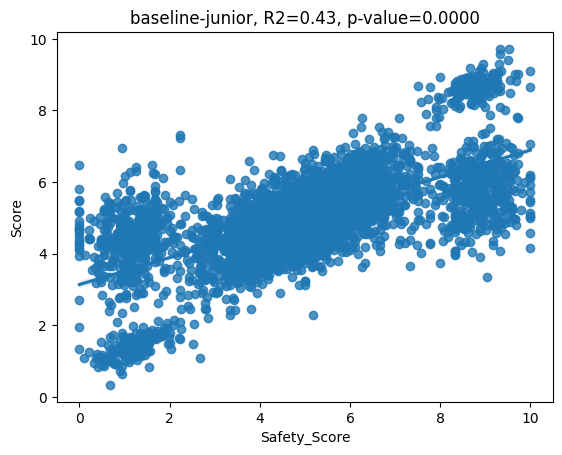

In [230]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
import seaborn as sns

sns.regplot(data=a_merge, y='Score', x='Safety_Score')
X = a_merge['Score'].values.reshape(-1, 1)
y = a_merge['Safety_Score'].values

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Get the regression parameters
slope = model.coef_[0]
intercept = model.intercept_
# Calculate R-squared and p-value
r_value, p_value = model.score(X, y), linregress(a_merge['Score'], a_merge['Safety_Score']).pvalue
plt.title(f"baseline-junior, R2={r_value:.2f}, p-value={p_value:.4f}")
# print(f"R2={r_value:.2f}, p-value={p_value:.4f}")

In [231]:
original_male = pd.read_csv("/data2/cehou/LLM_safety/Stockholm/safety_score_senior.csv")
original_male.rename(columns={"Score":"Safety_Score"},inplace=True)
baseline_pred = pd.read_csv("/data2/cehou/LLM_safety/Stockholm/tinetune_model_output/Stockholm_dataset_baseline_finetune_output.csv")
pred1 = pd.read_csv("/data2/cehou/LLM_safety/Stockholm/tinetune_model_output/Stockholm_dataset_30_male_finetune_output.csv")
pred2 = pd.read_csv("/data2/cehou/LLM_safety/Stockholm/tinetune_model_output/Stockholm_dataset_30_female_finetune_output.csv")
pred = pred1[['panoid', 'pred_score']].merge(pred2[['panoid', 'pred_score']], on='panoid', how='inner')
pred['pred_score'] = (pred['pred_score_x'] + pred['pred_score_y']) / 2

In [232]:
baseline_merged_data = baseline_pred.merge(original_male[['Image_ID','Safety_Score']], left_on='panoid', right_on='Image_ID', how='left')
baseline_merged_data = baseline_merged_data.dropna(subset=['pred_score', 'Safety_Score'])
baseline_merged_data['pred_score_label'] = baseline_merged_data['pred_score'].apply(lambda x: 'low' if x < 5 else 'high')
baseline_merged_data['Safety_Score_label'] = baseline_merged_data['Safety_Score'].apply(lambda x: 'low' if x < 5 else 'high')

male_merged_data = pred.merge(original_male[['Image_ID','Safety_Score']], left_on='panoid', right_on='Image_ID', how='left')
male_merged_data = male_merged_data.dropna(subset=['pred_score', 'Safety_Score'])
male_merged_data['pred_score_label'] = male_merged_data['pred_score'].apply(lambda x: 'low' if x < 5 else 'high')
male_merged_data['Safety_Score_label'] = male_merged_data['Safety_Score'].apply(lambda x: 'low' if x < 5 else 'high')

compare_merged = male_merged_data[['panoid','pred_score']].merge(baseline_merged_data[['panoid','pred_score']], on='panoid', how='inner')

0.8652063835496513
0.8652063835496513 0.0


Text(0.5, 1.0, 'baseline-finetuned junior, R2=0.87, p-value=0.0000')

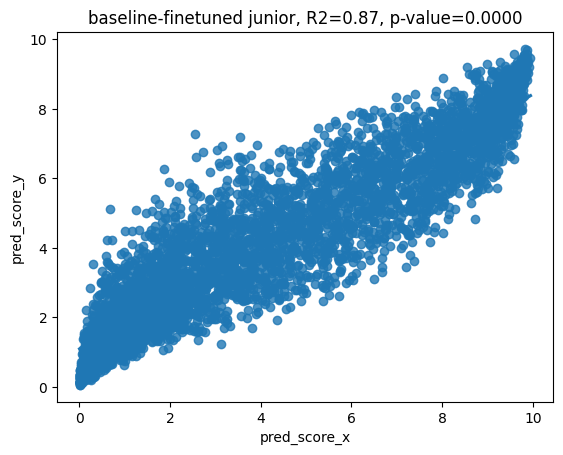

In [234]:
sns.regplot(data=compare_merged, x='pred_score_x', y='pred_score_y')
# Create and fit the model

X = compare_merged['pred_score_x'].values.reshape(-1, 1)
y = compare_merged['pred_score_y'].values

model = LinearRegression()
model.fit(X, y)

# Get the regression parameters
slope = model.coef_[0]
intercept = model.intercept_
# Calculate R-squared and p-value
r_value, p_value = model.score(X, y), linregress(aaa['pred_score_x'], aaa['pred_score_y']).pvalue
# Calculate R-squared using an alternative method
y_pred = model.predict(X)
ss_res = np.sum((y - y_pred) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r2_alternative = 1 - (ss_res / ss_tot)
print(r2_alternative)
print(r_value, p_value)
plt.title(f"baseline-finetuned junior, R2={r_value:.2f}, p-value={p_value:.4f}")
